In [72]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from sklearn import linear_model



import numpy as np
import pandas as pd
import copy
import random

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata



In [73]:
df_stores = pd.read_csv('../walmart_data/stores.csv')
df_test = pd.read_csv('../walmart_data/test.csv')
df_train = pd.read_csv('../walmart_data/train.csv')
df_features = pd.read_csv('../walmart_data/features.csv')

In [20]:
df = df_train[df_train['Dept'] == 3]
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
286,1,3,2010-02-05,13740.12,False
287,1,3,2010-02-12,10887.84,True
288,1,3,2010-02-19,11523.47,False
289,1,3,2010-02-26,11135.17,False
290,1,3,2010-03-05,12275.58,False


In [75]:
def hsvt(X, rank): 
    u, s, v = np.linalg.svd(X, full_matrices=False)
    s[rank:].fill(0)
    return np.dot(u*s, v) 

def linear_regression(X, y):
    regr = linear_model.LinearRegression(fit_intercept=False)
    regr.fit(X, y)
    return regr.coef_

In [76]:
def get_total_time(df, columns):
    return len(df[columns])

def concat(X1, X2):
    return np.hstack([X1, X2]) if X1.size else X2


def get_pre_intervention_df(X, T_0, T, k):
    X_pre = pd.DataFrame()
    i = 0
    for idx in range(k):
        if X.ndim > 1:
            X_temp = X.iloc[:, i: i+T_0]
        else:
            X_temp = X.iloc[i: i+T_0]
        X_pre = pd.concat([X_pre, X_temp], ignore_index=True, axis=1) if X_pre.size else X_temp
        i += T
    return X_pre

def get_post_intervention(X, T_0, T, k):
    X_post = pd.DataFrame()
    i = 0
    for idx in range(k):
        if X.ndim > 1:
            X_temp = X.iloc[:, i+T_0+1:i+T]
        else:
            X_temp = X.iloc[i+T_0+1: i+T]
        X_post = pd.concat([X_post, X_temp], ignore_index=True, axis=1) if X_post.size else X_temp
        i += T
    return X_post



def get_pre_intervention(X, T_0, T, k):
    X_pre = np.array([])
    i = 0
    for idx in range(k):
        if X.ndim > 1:
            X_temp = X[:, i: i+T_0]
        else:
            X_temp = X[i: i+T_0]
        X_pre = np.hstack([X_pre, X_temp]) if X_pre.size else X_temp
        i += T
    return X_pre

def get_diagonal(weights, T):
    k = len(weights)
    diag_matrix = np.zeros((k*T, k*T))
    i = 0
    for weight in weights:
        rng = np.arange(i, i+T)
        diag_matrix[rng, rng] = weight
        i += T
    return diag_matrix

def mse(y1, y2):
    return np.sum((y1 - y2) ** 2) / len(y1)

def avg_mse(err_dict, num_depts):
    train_error = 0
    test_error = 0
    for err in err_dict.values():
        train_error += err[0]
        test_error += err[2]
    return (train_error / num_depts, test_error / num_depts)

def plot(y_obs, y_pseudo, T_0, i, method, save_fig=False):
    fig, ax = plt.subplots()
    ax.plot(y_obs, label='Actual', color='grey')
    ax.plot(y_pseudo, label='Prediction', color='b')
    ax.plot([T_0, T_0], [ax.get_ylim()[0], ax.get_ylim()[1]], '--', linewidth=4, color='k')
    legend=ax.legend(loc='best', shadow=True, prop={'size': 9.5})
    frame=legend.get_frame()
    frame.set_facecolor('0.925')
    plt.title('Store {} Department {} Sales: {}'.format(1, i, method))
    plt.ylabel('Weekly Sales')
    plt.xlabel('Time')
    if save_fig: 
        fig_title = 'store{}_dept{}_{}_{}'.format(1, i, T_0, method)
        fig.savefig('{}.png'.format(fig_title), bbox_inches='tight')

In [21]:
""" convert to correct form """ 
# parameters:
train_pcts = [0.1, 0.3, 0.5, 0.75, 0.9]
val_pct = 0.3
t = sys.float_info.max

# get total weeks
T = len(df_train[(df_train['Store'] == 1) & (df_train['Dept'] == 1)])

# departments
depts1 = [2,5,6,7,14,23,46,55]
depts2 = [3,31,16,56]
depts3 = [17,21,22,32,55]
depts4 = [10,14,18,21]



weights_dict1 = {0: (2/3, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21),
                1: (1/21, 2/3, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21),
                2: (1/21, 1/21, 2/3, 1/21, 1/21, 1/21, 1/21, 1/21),
                3: (1/21, 1/21, 1/21, 2/3, 1/21, 1/21, 1/21, 1/21),
                4: (1/21, 1/21, 1/21, 1/21, 2/3, 1/21, 1/21, 1/21),
                5: (1/21, 1/21, 1/21, 1/21, 1/21, 2/3, 1/21, 1/21),
                6: (1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 2/3, 1/21),
                7: (1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 1/21, 2/3)}

weights_dict2 = {0: (2/3, 1/9, 1/9, 1/9),
                1: (1/9, 2/3, 1/9, 1/9),
                2: (1/9, 1/9, 2/3, 1/9),
                3: (1/9, 1/9, 1/9, 2/3)}

weights_dict3 = {0: (2/3, 1/12, 1/12, 1/12, 1/12),
                1: (1/12, 2/3, 1/12, 1/12, 1/12),
                2: (1/12, 1/12, 2/3, 1/12, 1/12),
                3: (1/12, 1/12, 1/12, 2/3, 1/12),
                4: (1/12, 1/12, 1/12, 1/12, 2/3)}

dept_scores1 = {dept: (t, t, t) for dept in depts1}
dept_scores2 = {dept: (t, t, t) for dept in depts2}
dept_scores3 = {dept: (t, t, t) for dept in depts3}

# pre-intervention
T_0s = [int(np.ceil(train_pct * T)) for train_pct in train_pcts]
test_periods = [T - T_0 for T_0 in T_0s]
val_idxs = [random.sample(range(test_period), int(val_pct * test_period)) for test_period in test_periods]

In [22]:
T_0s

[15, 43, 72, 108, 129]

In [23]:
# parameters
weights_dict = weights_dict2
dept_scores = dept_scores2
depts = depts4

scores_mrsc = [{dept: (t, t, t) for dept in depts} for train_pct in train_pcts]
scores_rsc = [{dept: (t, t, t) for dept in depts} for train_pct in train_pcts]
y_pseudos = [{dept: [] for dept in depts} for train_pct in train_pcts]
y_s = [{dept: [] for dept in depts} for train_pct in train_pcts]

num_dept = len(depts)

""" MRSC """
# iterate through all different intervention points
for i in range(len(train_pcts)):
    T_0 = T_0s[i]
    val_idx = np.unique(val_idxs[i])
    test_idx = np.ma.array(range(test_periods[i]), mask=False)
    test_idx.mask[val_idxs[i]] = True
    test_idx = test_idx.compressed()
    score = scores_mrsc[i]
    y_pseudo = y_pseudos[i]
    y = y_s[i]
    # for each intervention, use weights
    for idx, weight in weights_dict.items():
        w_matrix = get_diagonal(weight, T)
        inv_w_matrix = np.diag(1 / np.diag(w_matrix))

        """ concatenate """
        A_total = np.array([])
        Y_total = np.array([])
        Y_pre = np.array([])
        df_all=pd.DataFrame()


        for dept in depts:
            df_dept = df_train[df_train['Dept'] == dept]
            df_dept = df_dept.pivot_table(values='Weekly_Sales', index='Store', columns='Date')
            
            df_dept.fillna(df_dept.mean(), inplace=True)
            
            # convert to matrix and impute nans
            A_dept = df_dept.values
            A_dept[np.isnan(A_dept)] = np.nanmean(A_dept)
            
            # total donor matrix
            A_total = concat(A_total, A_dept[1:, :])
            df_all = pd.concat([df_all, df_dept], axis=1)
           
            # total treatment unit
            Y_dept = A_dept[0, :]
            Y_total = concat(Y_total, Y_dept)

        #weight matrices appropriately
        A_total = A_total.dot(w_matrix)
        Y_total = Y_total.dot(w_matrix)
        
        Y_pre = get_pre_intervention(Y_total, T_0, T, num_dept)
        A_total_hat = hsvt(A_total, rank=5)
        A_pre_hat = get_pre_intervention(A_total, T_0, T, num_dept)
        
        df_pre = get_pre_intervention_df(df_all.dot(w_matrix), T_0, T, num_dept)
        df_post = get_post_intervention(df_all.dot(w_matrix), T_0, T, num_dept)
        trainDF = df_pre.transpose()
        
        
        #the column name for the store under intervention is always "1"
        otherStates=list(trainDF.columns.values)
        unitOfIntervention=1
        
       
        
        otherStates.remove(unitOfIntervention)
        singvals = 5
        rscModel = RobustSyntheticControl(unitOfIntervention, singvals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()

        
        """ Linear Regression """
        beta = rscModel.model.weights 
        
        """ Prediction """
        Y_pseudo_total = A_total.T.dot(beta) 
        
        # convert back to original values
        Y_total = Y_total.dot(inv_w_matrix)
        Y_pseudo_total = Y_pseudo_total.dot(inv_w_matrix)
        
        
       
        
        j = 0
        for dept in depts:
            Y_total_dept = Y_total[j: j + T]
            Y_pseudo_dept = Y_pseudo_total[j: j + T]
            j += T

            train_mse = mse(Y_total_dept[:T_0], Y_pseudo_dept[:T_0])
            val_mse = mse(Y_total_dept[val_idx], Y_pseudo_dept[val_idx])
            test_mse = mse(Y_total_dept[T_0:], Y_pseudo_dept[T_0:])
            
            if test_mse <= score[dept][2]:
                score[dept] = (train_mse, val_mse, test_mse)
                y_pseudo[dept] = Y_pseudo_dept
                y[dept] = Y_total_dept
                
            #plot(Y_total_dept, Y_pseudo_dept, T_0, dept, method='mrsc', save_fig=False)
            
    scores_mrsc[i] = score
    y_pseudos[i] = y_pseudo
    y_s[i] = y


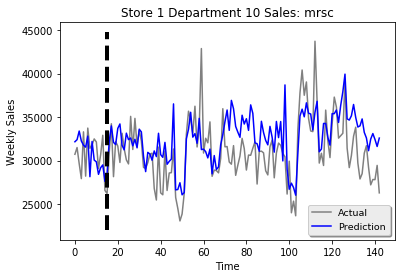

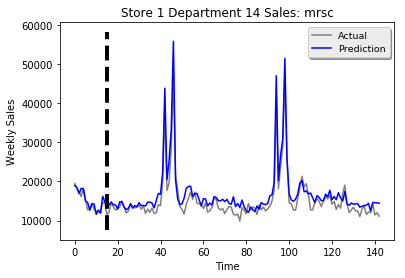

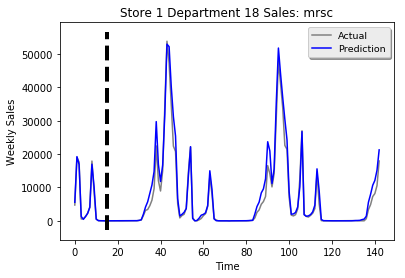

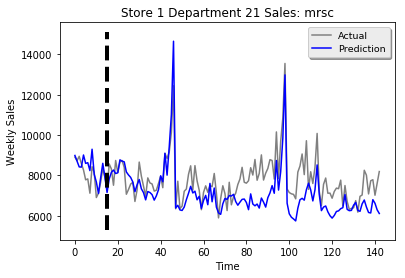

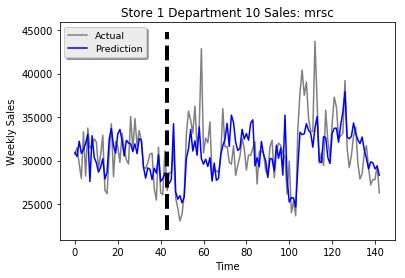

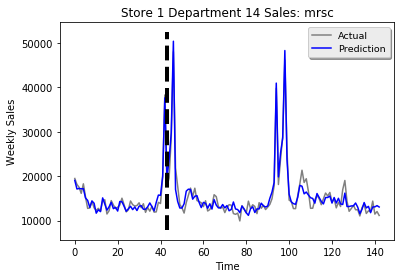

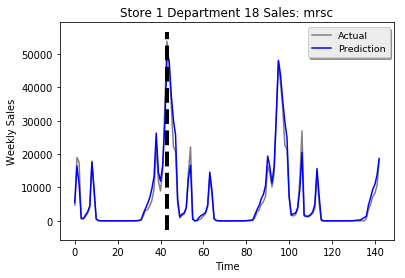

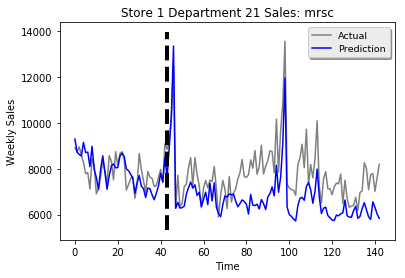

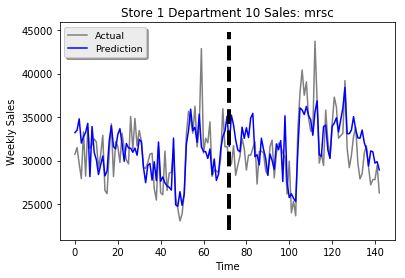

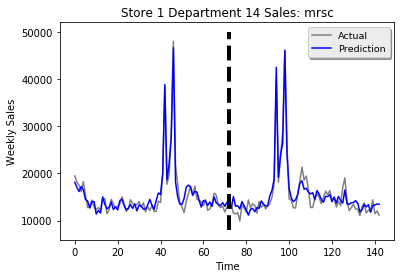

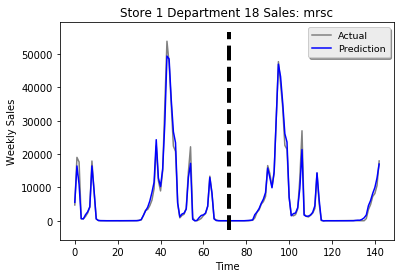

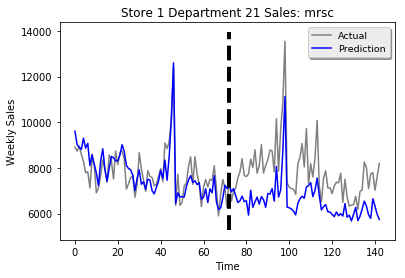

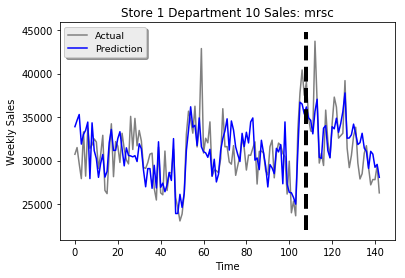

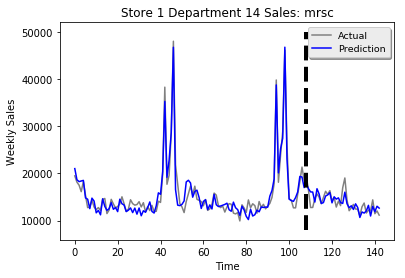

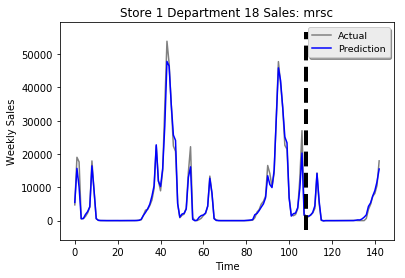

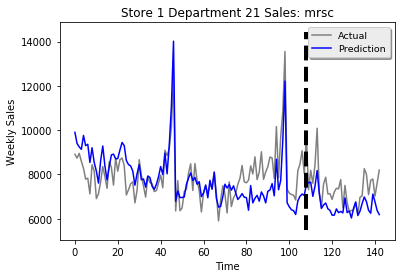

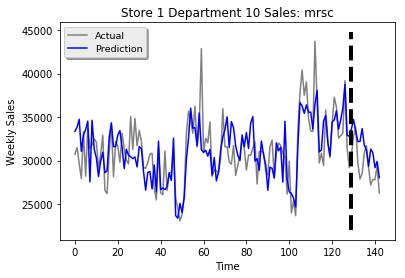

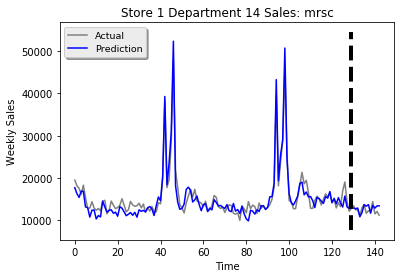

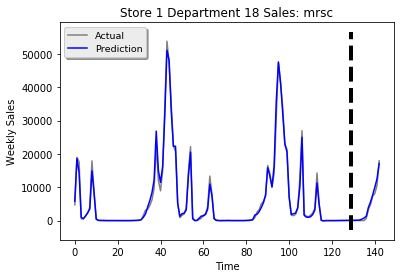

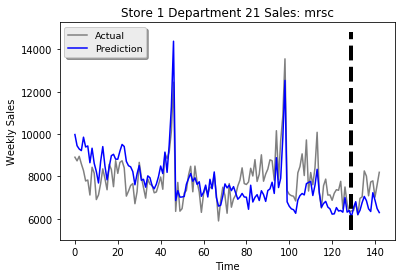

Done!


In [24]:
for i in range(len(train_pcts)):
    T_0 = T_0s[i]
    y1 = y_s[i]
    y2 = y_pseudos[i]
    for dept in depts:
        plot(y1[dept], y2[dept], T_0, dept, method='mrsc', save_fig=True)
        plt.show()
print("Done!")

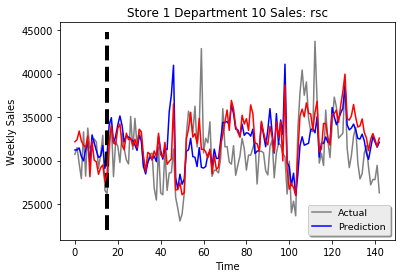

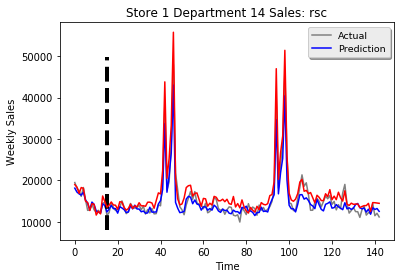

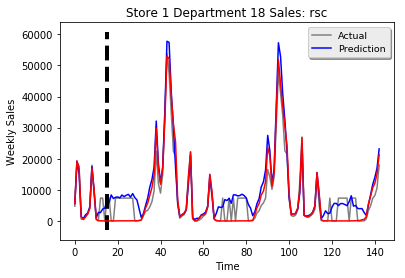

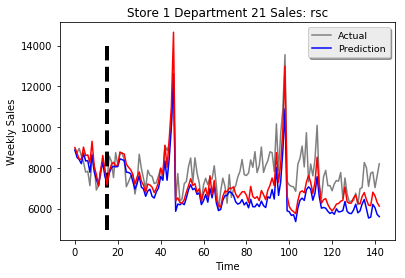

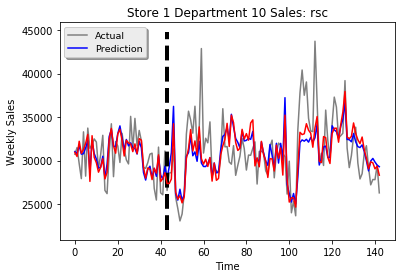

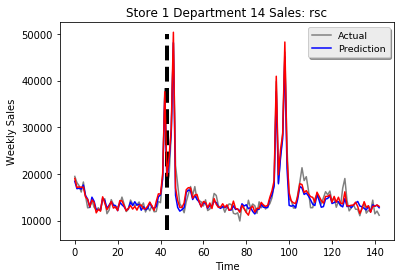

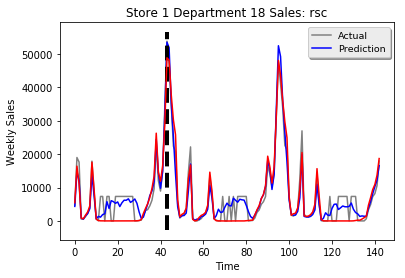

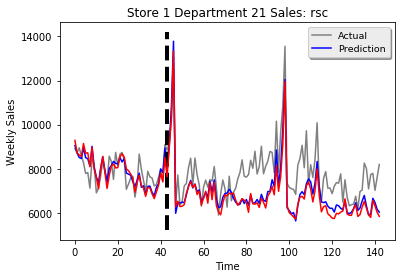

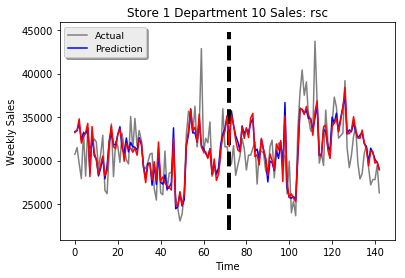

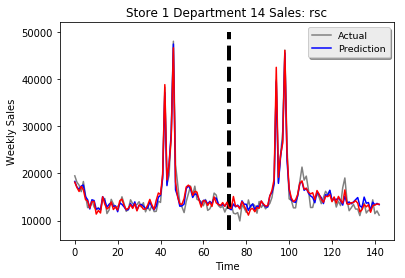

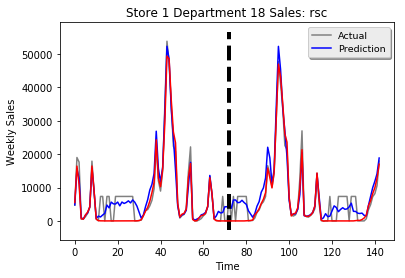

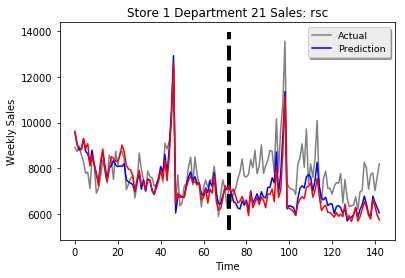

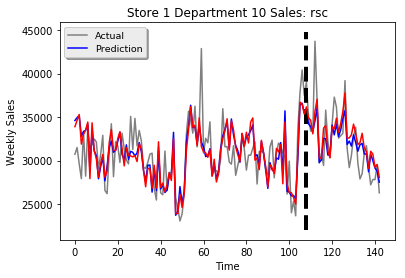

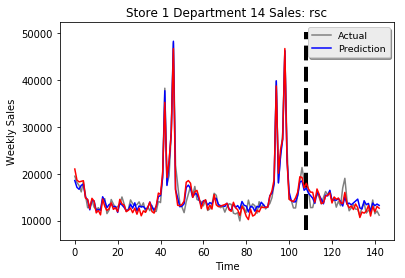

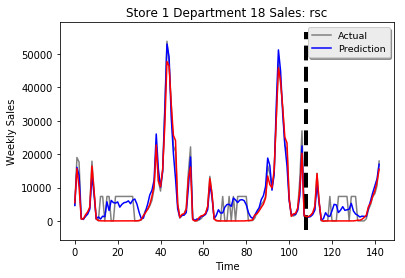

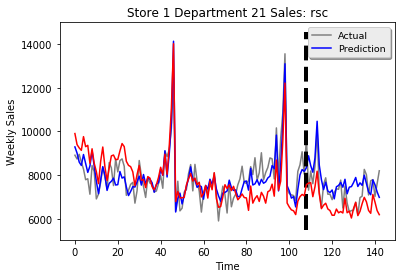

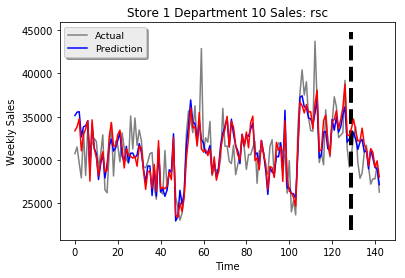

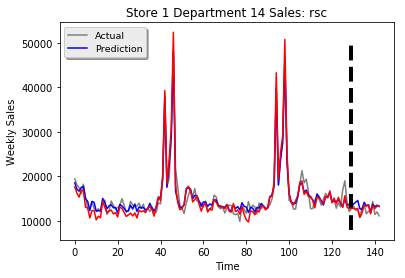

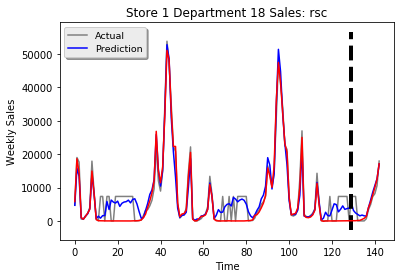

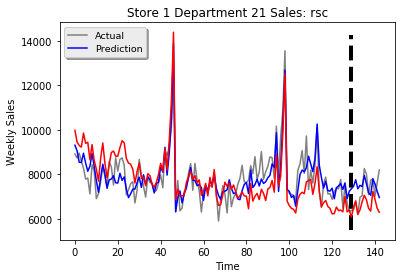

In [25]:
""" RSC """
for i in range(len(train_pcts)):
    T_0 = T_0s[i]
    val_idx = np.unique(val_idxs[i])
    test_idx = np.ma.array(range(test_periods[i]), mask=False)
    test_idx.mask[val_idxs[i]] = True
    test_idx = test_idx.compressed()
    score = scores_rsc[i]
    y2 = y_pseudos[i]
    for dept in depts:
        # convert to matrix and impute nans
        df_dept = df_train[df_train['Dept'] == dept]
        df_dept = df_dept.pivot_table(values='Weekly_Sales', index='Store', columns='Date')
        A_dept = df_dept.values
        A_dept[np.isnan(A_dept)] = np.nanmean(A_dept)
        
        # get total
        df_all = df_dept


        A_total_dept = A_dept[1:, :]
        Y_total_dept = A_dept[0, :]

        # get pre-int.
        Y_pre_dept = Y_total_dept[:T_0]

        # hsvt
        A_total_dept_hat = hsvt(A_total_dept, rank=5)
        A_pre_dept_hat = A_total_dept_hat[:, :T_0]
        
        df_pre = df_all.iloc[:,:T_0]
        
        trainDF = df_pre.transpose()
        
        
        #the column name for the store under intervention is always "1"
        otherStates=list(trainDF.columns.values)
        unitOfIntervention=1
        
       
        
        otherStates.remove(unitOfIntervention)
        singvals = 5
        rscModel = RobustSyntheticControl(unitOfIntervention, singvals, len(trainDF), probObservation=1.0, modelType='svd', svdMethod='numpy', otherSeriesKeysArray=otherStates)
        rscModel.fit(trainDF)
        denoisedDF = rscModel.model.denoisedDF()


        
        # linear regression
        #beta = linear_regression(A_pre_dept_hat.T, Y_pre_dept)
        
        beta = rscModel.model.weights

        # predict
        Y_pseudo_dept = A_total_dept_hat.T.dot(beta)

        # plot
        plot(Y_total_dept, Y_pseudo_dept, T_0, dept, method='rsc', save_fig=False)
        plt.plot(y2[dept], color='red', label='mrsc')
        plt.show()

        # evaluate
        train_mse = mse(Y_total_dept[:T_0], Y_pseudo_dept[:T_0])
        val_mse = mse(Y_total_dept[val_idx], Y_pseudo_dept[val_idx])
        test_mse = mse(Y_total_dept[T_0:], Y_pseudo_dept[T_0:])
        score[dept] = (train_mse, val_mse, test_mse)
        
    scores_rsc[i] = score